In [5]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None, 
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):
        
        color = next(color_cycle)
        
        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)
    

def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return
    
    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')
    
    
def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):    
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values
    
    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5
    
    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold
    
    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]
    
    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}
    
    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)
    
    distances = []
    angles = []
    speed_list = []
    speed_list_calib = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) & 
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            saccade_calib_speed_profile = saccade_samples['speed_r'].values * magnitude_calib 
            speed_list.append(saccade_speed_profile)
            speed_list_calib.append(saccade_calib_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])
        
        angles.append(overall_angle)  
        distances.append(distance_traveled)
        
        
    
    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
        saccade_events_df['speed_profile_calib'] = speed_list_calib
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)
        
    return df, saccade_events_df


In [6]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


# Example usage:
animals = ['PV_62','PV_126']
block_lists = [[23,24,26,38],[7,8,9]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)

instantiated block number 023 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_023, new OE version
Found the sample rate for block 023 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 023
got it!
instantiated block number 024 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_024, new OE version
Found the sample rate for block 024 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 024
got it!
instantiated block number 026 at Path: Z:\Nimrod\experiments\PV_62\2023_04_27\block_026, new OE version
Found the sample rate for block 026 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 026
got it!
instantiated block number 038 at Path: Z:\Nimrod\experi

In [7]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later
    
    # calibrate pupil diameter:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

running parse_open_ephys_events...
block 023 has a parsed events file, reading...
Getting eye brightness values for block 023...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 024 has a parsed events file, reading...
Getting eye brightness values for block 024...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 026 has a parsed events file, reading...
Getting eye brightness values for block 026...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

In [8]:
# saccade detection and annotation: 
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_df(block.left_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=True,
                                                               magnitude_calib=block.L_pix_size)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_df(block.right_eye_data,
                                                               speed_threshold=4,
                                                               bokeh_verify_threshold=False,
                                                               magnitude_calib=block.R_pix_size)


70it [00:00, 686.28it/s]

PV_62, block 023, on 2023-04-27_10-52-42


602it [00:00, 748.73it/s]
599it [00:00, 687.72it/s]
79it [00:00, 789.75it/s]

PV_62, block 024, on 2023-04-27_11-22-56


602it [00:00, 770.78it/s]
599it [00:00, 699.72it/s]
77it [00:00, 762.38it/s]

PV_62, block 026, on 2023-04-27_12-21-41


598it [00:00, 769.60it/s]
579it [00:00, 728.30it/s]
74it [00:00, 732.88it/s]

PV_62, block 038, on 2023-05-01_13-57-45


1126it [00:01, 711.31it/s]
1123it [00:01, 686.85it/s]
71it [00:00, 703.16it/s]

PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12


1209it [00:01, 732.51it/s]
1180it [00:01, 716.67it/s]
70it [00:00, 693.10it/s]

PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41


366it [00:00, 670.33it/s]
399it [00:00, 635.82it/s]
72it [00:00, 719.99it/s]

PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15


359it [00:00, 712.33it/s]
434it [00:00, 680.23it/s]


In [9]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}
        
        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')
        
    return

for block in block_collection:
    block_get_lizard_movement(block)

# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms
        
        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]
        
        if overlapping_mov_times.size > 0:  
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

for block in block_collection:
    label_saccade_movements(block)


path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_023\oe_files\2023-04-27_10-52-42\Record Node 108\analysis\recNames=Block0023,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 023, on 2023-04-27_10-52-42
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_024\oe_files\2023-04-27_11-22-56\Record Node 108\analysis\recNames=Block0024,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 024, on 2023-04-27_11-22-56
path to mat file is Z:\Nimrod\experiments\PV_62\2023_04_27\block_026\oe_files\2023-04-27_12-21-41\Record Node 108\analysis\recNames=Block0026,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 026, on 2023-04-27_12-21-41
path to mat file is Z:\Nimrod\experiments\PV_62\2023_05_01\block_038\oe_files\2023-05-01_13-57-45\Record Node 108\analysis\recNames=Block0038,Animal=PV_62\lizMov.mat
liz_mov_df created for PV_62, block 038, on 2023-05-01_13-57-45
path to mat file is Z:\Nimrod\experiments\PV_126\2024_07_18\block_007\oe_files\P

In [10]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [11]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [12]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])
    
    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')
        
    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


577it [00:00, 7036.60it/s]
577it [00:00, 7904.04it/s]
0it [00:00, ?it/s]

199 568
199 568


575it [00:00, 7875.89it/s]
1034it [00:00, 8914.04it/s]


190 547


1163it [00:00, 7268.63it/s]

599 1064



341it [00:00, 7750.18it/s]
338it [00:00, 7352.02it/s]


342 1110
181 386
204 414


In [13]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [14]:
all_saccade_collection = pd.concat([synced_saccade_collection,non_synced_saccade_collection])

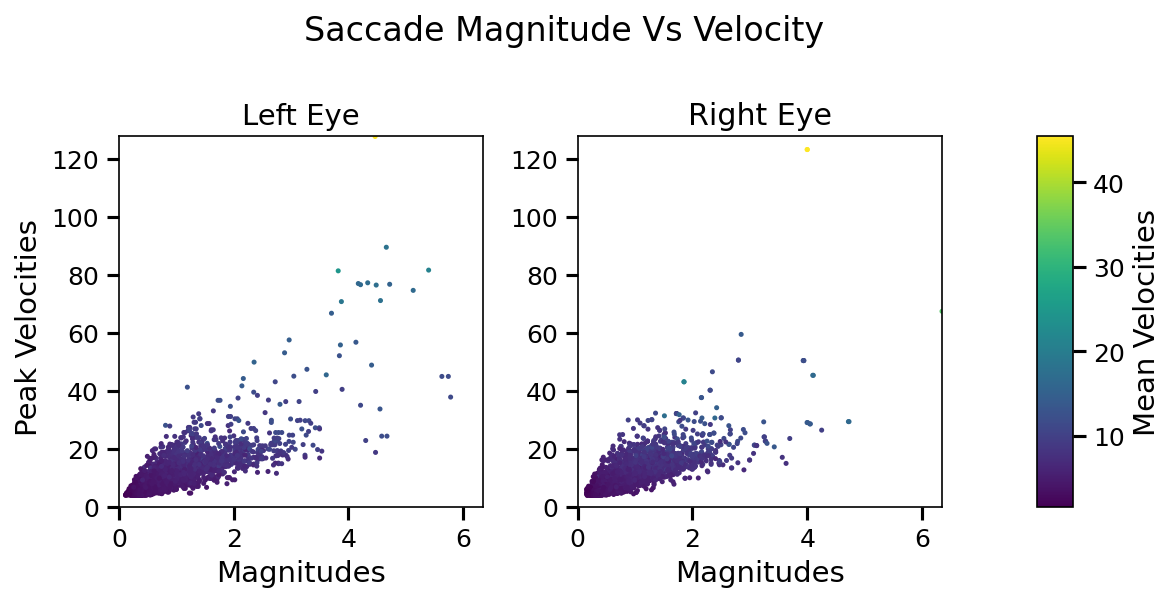

In [11]:
# This cell creates the saccade magnitude Vs velocity graphs:
l_magnitudes = synced_saccade_collection.query('eye == "L"').magnitude.values
l_peak_velocities = np.array([np.nanmax(i) for i in synced_saccade_collection.query('eye == "L"').speed_profile])
l_mean_velocities = np.array([np.nanmean(i) for i in synced_saccade_collection.query('eye == "L"').speed_profile])
r_magnitudes = synced_saccade_collection.query('eye == "R"').magnitude.values
r_peak_velocities = np.array([np.nanmax(i) for i in synced_saccade_collection.query('eye == "R"').speed_profile])
r_mean_velocities = np.array([np.nanmean(i) for i in synced_saccade_collection.query('eye == "R"').speed_profile])

all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
all_mean_velocities = np.concatenate((l_mean_velocities, r_mean_velocities))

x_min, x_max = all_magnitudes.min(), all_magnitudes.max()
y_min, y_max = all_peak_velocities.min(), all_peak_velocities.max()

# Find global min and max for mean velocities
c_min, c_max = all_mean_velocities.min(), all_mean_velocities.max()

fig, axs = plt.subplots(1,3, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1, 0.1]}, dpi=150)

# Left eye scatter plot
sc_left = axs[0].scatter(l_magnitudes, l_peak_velocities, s=2,c=l_mean_velocities, cmap='viridis')
axs[0].set_xlabel('Magnitudes', fontsize=10)
axs[0].set_ylabel('Peak Velocities ', fontsize=10)
axs[0].set_title('Left Eye', fontsize=10)
axs[0].grid(False)
axs[0].set_xlim([0, x_max])
axs[0].set_ylim([0, y_max])


# Right eye scatter plot
sc_right = axs[1].scatter(r_magnitudes, r_peak_velocities,s=2, c=r_mean_velocities, cmap='viridis')
# cbar_right = plt.colorbar(sc_right, ax=axs[1])
# cbar_right.set_label('Mean Velocities', fontsize=16)
axs[1].set_xlabel('Magnitudes', fontsize=10)
#axs[1].set_ylabel('Peak Velocities', fontsize=16)
axs[1].set_title('Right Eye')
axs[1].grid(False)
axs[1].set_xlim([0, x_max])
axs[1].set_ylim([0, y_max])

# Set subplot backgrounds to white
axs[0].set_facecolor('white')
axs[1].set_facecolor('white')

for ax in axs:
    #ax.spines['top'].set_visible(True)
    #ax.spines['right'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
    # Set spine color
    #ax.spines['top'].set_color('black')
    #ax.spines['right'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.spines['left'].set_color('black')

    ax.tick_params(axis='both', direction='out', which='major',length=6, width=1.5, colors='black', bottom=True, left=True)
    ax.tick_params(axis='both', direction='out', which='minor', length=3, width=1.5,colors='black', bottom=True, left=True)
    
    
cbar = plt.colorbar(sc_right, cax=axs[2])
cbar.ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
cbar.set_label('Mean Velocities', fontsize=14)

# final touches
fig.suptitle('Saccade Magnitude Vs Velocity', y=1.00, x=0.48, fontsize=16)
plt.tight_layout()
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
#export_to = rf'D:\MarkS3\Pictures\Graphs\2024_Head_mounted_eyecam_system\Current_Paradigm\PV_126\{t}_saccade_magnitude_Vs_Velocity_Vs_mean_Velocity.pdf'
#plt.savefig(export_to, format='pdf')
plt.show()

In [12]:
import os
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

def remove_outliers_from_df(df, threshold=3):
    """
    Removes rows with outliers from all columns based on a standard deviation threshold.

    Parameters:
    - df: pandas DataFrame with columns to evaluate.
    - threshold: number of standard deviations for outlier removal.

    Returns:
    - Cleaned DataFrame with outliers removed.
    """
    mask = (np.abs(df - df.mean()) <= threshold * df.std()).all(axis=1)
    return df[mask]


def plot_saccade_magnitude_vs_velocity(
    magnitudes, peak_velocities, mean_velocities, export_path=None, threshold=3
):
    """
    Plots saccade magnitudes vs velocities and exports the plot and dataset.

    Parameters:
    - magnitudes: numpy array of saccade magnitudes.
    - peak_velocities: numpy array of peak velocities.
    - mean_velocities: numpy array of mean velocities.
    - export_path: Path for export directory (optional).
    - threshold: Standard deviation threshold for outlier removal.
    """
    # Combine data into DataFrame
    data = pd.DataFrame({
        'magnitude': magnitudes,
        'peak_velocity': peak_velocities,
        'mean_velocity': mean_velocities
    })

    # Remove outliers
    cleaned_data = remove_outliers_from_df(data, threshold)

    # Extract filtered data
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_mean_velocities = cleaned_data['mean_velocity'].values

    # Plot settings
    x_min, x_max = f_magnitudes.min(), f_magnitudes.max()
    y_min, y_max = f_peak_velocities.min(), f_peak_velocities.max()

    fig, axs = plt.subplots(1, 3, figsize=(8, 4), gridspec_kw={'width_ratios': [1, 1, 0.1]}, dpi=300)

    # Left eye scatter plot
    sc_left = axs[0].scatter(f_magnitudes, f_peak_velocities, s=2, c=f_mean_velocities, cmap='viridis')
    axs[0].set_xlabel('Magnitudes', fontsize=10)
    axs[0].set_ylabel('Peak Velocities', fontsize=10)
    axs[0].set_title('Left Eye', fontsize=10)
    axs[0].set_xlim([0, x_max])
    axs[0].set_ylim([0, y_max])

    # Right eye scatter plot
    sc_right = axs[1].scatter(f_magnitudes, f_peak_velocities, s=2, c=f_mean_velocities, cmap='viridis')
    axs[1].set_xlabel('Magnitudes', fontsize=10)
    axs[1].set_title('Right Eye', fontsize=10)
    axs[1].set_xlim([0, x_max])
    axs[1].set_ylim([0, y_max])

    # Customize appearance
    for ax in axs[:2]:
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.tick_params(axis='both', direction='out', length=6, width=1.5, colors='black', bottom=True, left=True)

    # Colorbar
    cbar = plt.colorbar(sc_right, cax=axs[2])
    cbar.ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    cbar.set_label('Mean Velocities', fontsize=14)

    # Final touches
    fig.suptitle('Saccade Magnitude Vs Velocity', y=1.00, x=0.48, fontsize=16)
    plt.tight_layout()

    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        # Save data
        data_file = os.path.join(full_export_path, "cleaned_saccade_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


def load_and_plot_saccade_magnitude_vs_velocity(load_path, threshold=3):
    """
    Loads saccade data from a pickle file and re-plots the graph.

    Parameters:
    - load_path (str): Path to the export directory.
    - threshold (float): Outlier removal threshold for re-plotting.
    """
    data_file = os.path.join(load_path, "cleaned_saccade_data.pkl")

    try:
        with open(data_file, 'rb') as f:
            cleaned_data = pickle.load(f)
    except FileNotFoundError:
        print(f"Data file not found at {data_file}")
        return

    # Re-plot
    plot_saccade_magnitude_vs_velocity(
        cleaned_data['magnitude'].values,
        cleaned_data['peak_velocity'].values,
        cleaned_data['mean_velocity'].values,
        export_path=None,
        threshold=threshold
    )


In [18]:
def extract_saccade_metrics(saccade_collection, eye_label):
    """
    Extracts relevant saccade metrics from a saccade collection DataFrame.

    Parameters:
    - saccade_collection: DataFrame with saccade data.
    - eye_label: String ('L' or 'R') indicating the eye to filter.

    Returns:
    - magnitudes: numpy array of saccade magnitudes.
    - peak_velocities: numpy array of peak velocities.
    - mean_velocities: numpy array of mean velocities.
    """
    filtered_data = saccade_collection.query('eye == @eye_label')
    magnitudes = filtered_data['magnitude'].values
    peak_velocities = np.array([np.nanmax(i) for i in filtered_data['speed_profile']])
    mean_velocities = np.array([np.nanmean(i) for i in filtered_data['speed_profile']])

    return magnitudes, peak_velocities, mean_velocities


def plot_saccade_magnitude_vs_velocity_from_collections(
    synced_saccade_collection, monocular_saccade_collection, export_path=None, threshold=3
):
    """
    Plots saccade magnitudes vs velocities using synced and monocular saccade collections.

    Parameters:
    - synced_saccade_collection: DataFrame of synchronized saccades.
    - monocular_saccade_collection: DataFrame of monocular saccades.
    - export_path: Path for export directory (optional).
    - threshold: Standard deviation threshold for outlier removal.
    """
    # Extract metrics for both eyes
    l_magnitudes, l_peak_velocities, l_mean_velocities = extract_saccade_metrics(synced_saccade_collection, 'L')
    r_magnitudes, r_peak_velocities, r_mean_velocities = extract_saccade_metrics(synced_saccade_collection, 'R')

    # Concatenate all data
    all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
    all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
    all_mean_velocities = np.concatenate((l_mean_velocities, r_mean_velocities))

    # Combine into DataFrame and remove outliers
    data = pd.DataFrame({
        'magnitude': all_magnitudes,
        'peak_velocity': all_peak_velocities,
        'mean_velocity': all_mean_velocities
    })

    cleaned_data = remove_outliers_from_df(data, threshold)

    # Extract cleaned data
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_mean_velocities = cleaned_data['mean_velocity'].values

    # Plot settings
    x_min, x_max = f_magnitudes.min(), f_magnitudes.max()
    y_min, y_max = f_peak_velocities.min(), f_peak_velocities.max()

    fig, axs = plt.subplots(1, 3, figsize=(4, 2), gridspec_kw={'width_ratios': [1, 1, 0.1]}, dpi=300)

    # Left eye scatter plot
    sc_left = axs[0].scatter(f_magnitudes, f_peak_velocities, s=2, c=f_mean_velocities, cmap='viridis')
    axs[0].set_xlabel('Magnitudes', fontsize=10)
    axs[0].set_ylabel('Peak Velocities', fontsize=10)
    axs[0].set_title('Left Eye', fontsize=10)
    axs[0].set_xlim([0, x_max])
    axs[0].set_ylim([0, y_max])

    # Right eye scatter plot
    sc_right = axs[1].scatter(f_magnitudes, f_peak_velocities, s=0.5, c=f_mean_velocities, cmap='viridis')
    axs[1].set_xlabel('Magnitudes', fontsize=10)
    axs[1].set_title('Right Eye', fontsize=10)
    axs[1].set_xlim([0, x_max])
    axs[1].set_ylim([0, y_max])

    # Customize appearance
    for ax in axs[:2]:
        ax.spines['bottom'].set_visible(True)
        ax.spines['left'].set_visible(True)
        ax.tick_params(axis='both', direction='out', length=6, width=1.5, colors='black', bottom=True, left=True)

    # Colorbar
    cbar = plt.colorbar(sc_right, cax=axs[2])
    cbar.ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%d'))
    cbar.set_label('Mean Velocities', fontsize=10)

    # Final touches
    #fig.suptitle('Saccade Magnitude Vs Velocity', y=1.00, x=0.48, fontsize=10)
    plt.tight_layout()

    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        # Save data
        data_file = os.path.join(full_export_path, "cleaned_saccade_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


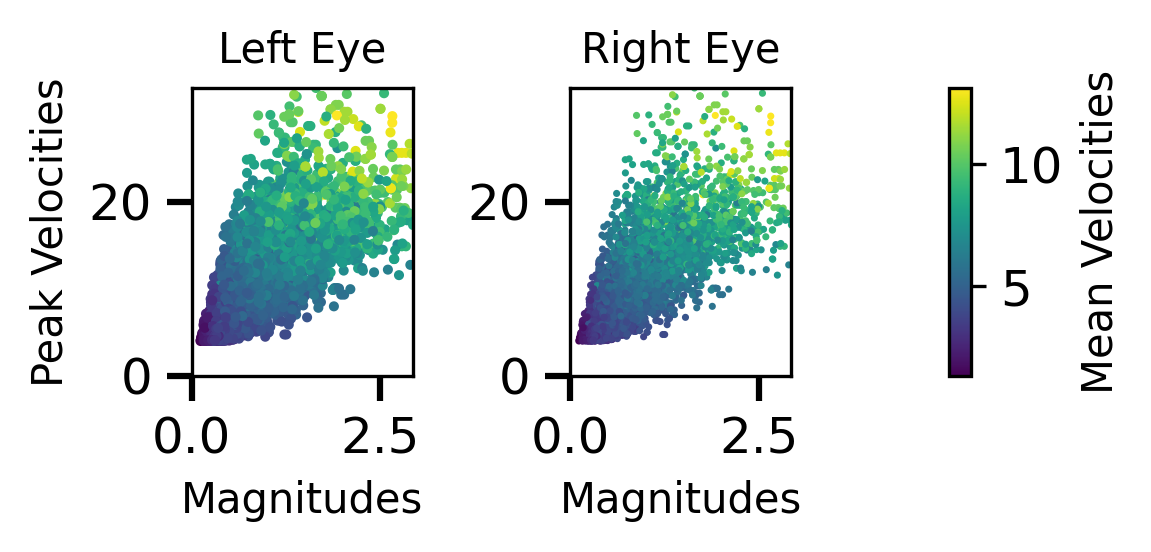

In [19]:
plot_saccade_magnitude_vs_velocity_from_collections(synced_saccade_collection,non_synced_saccade_collection)

In [38]:
def plot_saccade_magnitude_vs_velocity_compact(
    synced_saccade_collection, monocular_saccade_collection, export_path=None, threshold=3, fig_size=(3, 3)
):
    """
    Plots saccade magnitudes vs velocities as a compact single scatter plot with a colorbar.

    Parameters:
    - synced_saccade_collection: DataFrame of synchronized saccades.
    - monocular_saccade_collection: DataFrame of monocular saccades.
    - export_path: Path for export directory (optional).
    - threshold: Standard deviation threshold for outlier removal.
    - fig_size: Tuple specifying figure size (width, height).
    """
    # Extract metrics for both eyes
    l_magnitudes, l_peak_velocities, l_mean_velocities = extract_saccade_metrics(synced_saccade_collection, 'L')
    r_magnitudes, r_peak_velocities, r_mean_velocities = extract_saccade_metrics(synced_saccade_collection, 'R')

    # Concatenate all data
    all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
    all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
    all_mean_velocities = np.concatenate((l_mean_velocities, r_mean_velocities))

    # Combine into DataFrame and remove outliers
    data = pd.DataFrame({
        'magnitude': all_magnitudes,
        'peak_velocity': all_peak_velocities,
        'mean_velocity': all_mean_velocities
    })

    cleaned_data = remove_outliers_from_df(data, threshold)

    # Extract cleaned data
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_mean_velocities = cleaned_data['mean_velocity'].values

    # Plot settings
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    # Scatter plot
    sc = ax.scatter(f_magnitudes, f_peak_velocities, s=1, c=f_mean_velocities, cmap='viridis', alpha=0.7)

    # Customize appearance
    ax.set_xlabel('Magnitudes', fontsize=10)
    ax.set_ylabel('Peak Velocities', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    cbar.set_label('Mean Velocities', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # Axes equal and tight layout
    #ax.set_aspect('equal', 'box')
    plt.tight_layout()

    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_compact_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_compact.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        # Save data
        data_file = os.path.join(full_export_path, "cleaned_saccade_data_compact.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_magnitude_vs_velocity_compact_2024_12_19_19_15_36


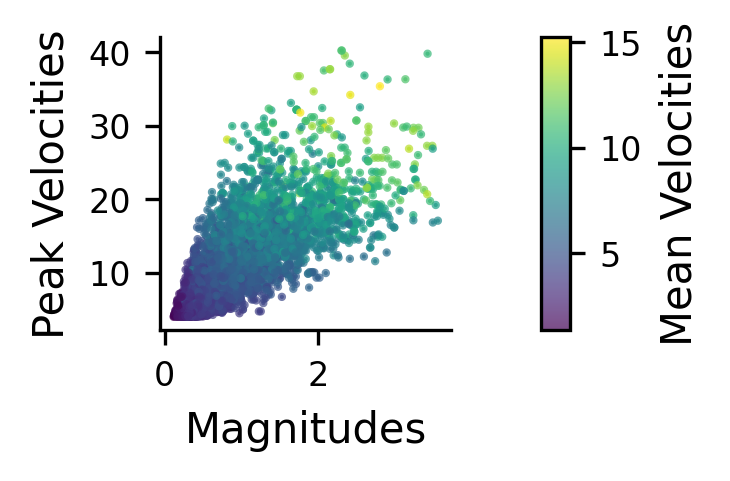

In [45]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials'
plot_saccade_magnitude_vs_velocity_compact(synced_saccade_collection,non_synced_saccade_collection,export_path=export_path,fig_size=(2.5,1.7),threshold=4)

In [49]:
from matplotlib.ticker import MultipleLocator, MaxNLocator
def remove_outliers_from_df(df, threshold=3):
    """
    Removes rows with outliers from all columns based on a standard deviation threshold.

    Parameters:
    - df: pandas DataFrame with columns to evaluate.
    - threshold: number of standard deviations for outlier removal.

    Returns:
    - Cleaned DataFrame with outliers removed.
    """
    mask = (np.abs(df - df.mean()) <= threshold * df.std()).all(axis=1)
    return df[mask]
def extract_saccade_metrics(saccade_collection, eye_label):
    """
    Extracts relevant saccade metrics from a saccade collection DataFrame.

    Parameters:
    - saccade_collection: DataFrame with saccade data.
    - eye_label: String ('L' or 'R') indicating the eye to filter.

    Returns:
    - magnitudes: numpy array of saccade magnitudes.
    - peak_velocities: numpy array of peak velocities.
    - mean_velocities: numpy array of mean velocities.
    """
    filtered_data = saccade_collection.query('eye == @eye_label')
    magnitudes = filtered_data['magnitude'].values
    peak_velocities = np.array([np.nanmax(i) for i in filtered_data['speed_profile_calib']])
    mean_velocities = np.array([np.nanmean(i) for i in filtered_data['speed_profile_calib']])

    return magnitudes, peak_velocities, mean_velocities


def plot_saccade_magnitude_vs_velocity_compact(
    synced_saccade_collection, monocular_saccade_collection, export_path=None, threshold=3, 
    fig_size=(3, 3), velocity_threshold=None, velocity_to_mm_per_ms=True, frame_rate_fps=60
):
    """
    Plots saccade magnitudes vs velocities as a compact single scatter plot with a colorbar.

    Parameters:
    - synced_saccade_collection: DataFrame of synchronized saccades.
    - monocular_saccade_collection: DataFrame of monocular saccades.
    - export_path: Path for export directory (optional).
    - threshold: Standard deviation threshold for outlier removal.
    - fig_size: Tuple specifying figure size (width, height).
    - velocity_threshold: Horizontal line value for peak velocities (optional).
    """
    # Extract metrics for both eyes
    l_magnitudes, l_peak_velocities, l_mean_velocities = extract_saccade_metrics(synced_saccade_collection, 'L')
    r_magnitudes, r_peak_velocities, r_mean_velocities = extract_saccade_metrics(synced_saccade_collection, 'R')

    # Concatenate all data
    all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
    all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
    all_mean_velocities = np.concatenate((l_mean_velocities, r_mean_velocities))
    
    if velocity_to_mm_per_ms:
        frame_rate_fps = frame_rate_fps
        frame_duration = 1000 / frame_rate_fps
        all_peak_velocities = all_peak_velocities / frame_duration
        all_mean_velocities = all_mean_velocities / frame_duration 
    # Combine into DataFrame and remove outliers
    data = pd.DataFrame({
        'magnitude': all_magnitudes,
        'peak_velocity': all_peak_velocities,
        'mean_velocity': all_mean_velocities
    })

    cleaned_data = remove_outliers_from_df(data, threshold)

    # Extract cleaned data
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_mean_velocities = cleaned_data['mean_velocity'].values

    # Plot settings
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    # Scatter plot
    sc = ax.scatter(f_magnitudes, f_peak_velocities, s=0.7, c=f_mean_velocities, cmap='viridis', alpha=0.7)

    # Customize appearance
    ax.set_xlabel('Amplitude [mm]', fontsize=10)
    ax.set_ylabel('Peak Velocity \n [mm/frame]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.xaxis.set_major_locator(MultipleLocator(1))
    #ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    # Add horizontal line if threshold is provided
    if velocity_threshold is not None:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)

    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    cbar.set_label('Mean Velocities', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # Axes equal and tight layout
    #ax.set_aspect('equal', 'box')
    #plt.tight_layout()

    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_compact_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_compact.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        # Save data
        data_file = os.path.join(full_export_path, "cleaned_saccade_data_compact.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


In [31]:
print('jh')

jh


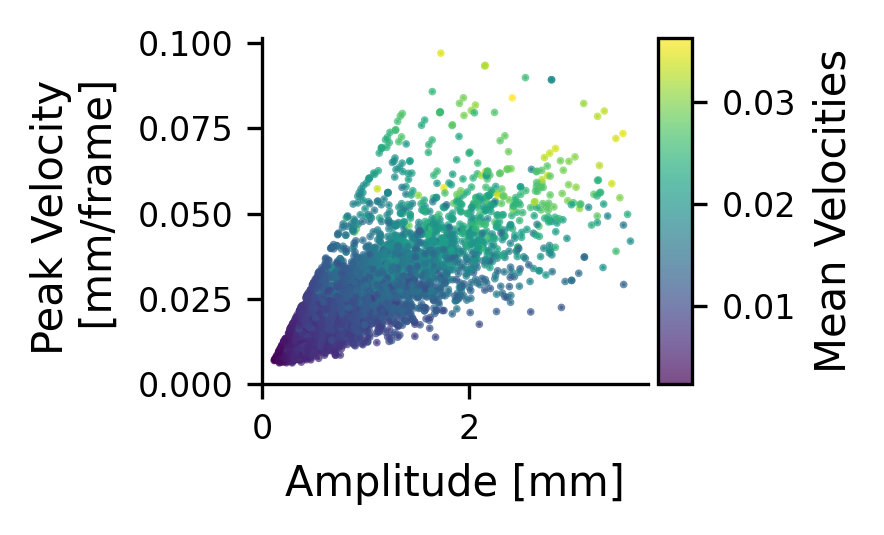

In [50]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials'
plot_saccade_magnitude_vs_velocity_compact(synced_saccade_collection,non_synced_saccade_collection,export_path=None,fig_size=(2,1.5),threshold=4,velocity_threshold=None)

16.666666666666668

In [84]:
from matplotlib.ticker import MultipleLocator, MaxNLocator
def remove_outliers_from_df(df, threshold=3):
    """
    Removes rows with outliers from all columns based on a standard deviation threshold.

    Parameters:
    - df: pandas DataFrame with columns to evaluate.
    - threshold: number of standard deviations for outlier removal.

    Returns:
    - Cleaned DataFrame with outliers removed.
    """
    mask = (np.abs(df - df.mean()) <= threshold * df.std()).all(axis=1)
    return df[mask]
def extract_saccade_metrics_length(saccade_collection, eye_label):
    """
    Extracts relevant saccade metrics from a saccade collection DataFrame.

    Parameters:
    - saccade_collection: DataFrame with saccade data.
    - eye_label: String ('L' or 'R') indicating the eye to filter.

    Returns:
    - magnitudes: numpy array of saccade magnitudes.
    - peak_velocities: numpy array of peak velocities.
    - mean_velocities: numpy array of mean velocities.
    """
    filtered_data = saccade_collection.query('eye == @eye_label')
    magnitudes = filtered_data['magnitude'].values
    peak_velocities = np.array([np.nanmax(i) for i in filtered_data['speed_profile_calib']])
    saccade_length = np.array([len(i) for i in filtered_data['speed_profile_calib']])

    return magnitudes, peak_velocities, saccade_length


def plot_saccade_magnitude_vs_velocity_length(
    synced_saccade_collection, monocular_saccade_collection, export_path=None, threshold=3, 
    fig_size=(3, 3), velocity_threshold=None, velocity_to_mm_per_ms=True, frame_rate_fps=60
):
    """
    Plots saccade magnitudes vs velocities as a compact single scatter plot with a colorbar.

    Parameters:
    - synced_saccade_collection: DataFrame of synchronized saccades.
    - monocular_saccade_collection: DataFrame of monocular saccades.
    - export_path: Path for export directory (optional).
    - threshold: Standard deviation threshold for outlier removal.
    - fig_size: Tuple specifying figure size (width, height).
    - velocity_threshold: Horizontal line value for peak velocities (optional).
    """
    # Extract metrics for both eyes
    l_magnitudes, l_peak_velocities, l_length = extract_saccade_metrics_length(synced_saccade_collection, 'L')
    r_magnitudes, r_peak_velocities, r_length = extract_saccade_metrics_length(synced_saccade_collection, 'R')

    # Concatenate all data
    all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
    all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
    all_lens = np.concatenate((l_length, r_length))
    frame_rate_fps = frame_rate_fps
    frame_duration = 1000 / frame_rate_fps
    if velocity_to_mm_per_ms:
        all_peak_velocities = all_peak_velocities / frame_duration 
    # Combine into DataFrame and remove outliers
    data = pd.DataFrame({
        'magnitude': all_magnitudes,
        'peak_velocity': all_peak_velocities,
        'length': all_lens
    })

    cleaned_data = remove_outliers_from_df(data, threshold)

    # Extract cleaned data
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_len = cleaned_data['length'].values

    # Plot settings
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    # Scatter plot
    sc = ax.scatter(f_magnitudes, f_peak_velocities, s=0.7, c=f_len, cmap='viridis', alpha=0.7)

    # Customize appearance
    ax.set_xlabel('Amplitude [mm]', fontsize=10)
    ax.set_ylabel('Peak Velocity \n [mm/ms]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    #ax.yaxis.set_major_locator(MultipleLocator(0.5))
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    # Add horizontal line if threshold is provided
    if velocity_threshold is not None:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)
    
    limiting_slope = 1 / frame_duration

    # Generate line points
    x_line = np.linspace(0, f_magnitudes.max(), 100)
    y_line = limiting_slope * x_line
    
    # Add line to the plot
    ax.plot(x_line, y_line, color='orange', linestyle='--', linewidth=1.5, label=f'Min Detectable Speed')
    ax.legend(fontsize=8)
    
    
    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    cbar.set_label('length [frames]', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # Axes equal and tight layout
    #ax.set_aspect('equal', 'box')
    #plt.tight_layout()

    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_compact_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_compact.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        # Save data
        data_file = os.path.join(full_export_path, "cleaned_saccade_data_compact.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\amplitude_velocity_length\saccade_magnitude_vs_velocity_compact_2024_12_20_18_09_41


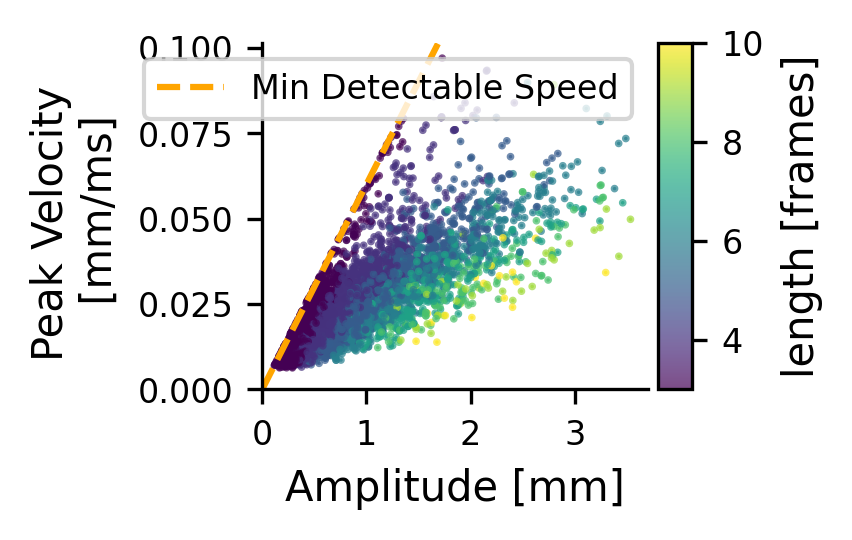

In [85]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\amplitude_velocity_length'
plot_saccade_magnitude_vs_velocity_length(synced_saccade_collection,non_synced_saccade_collection,export_path=export_path,fig_size=(2,1.5),threshold=4,velocity_threshold=None,velocity_to_mm_per_ms=True)

In [114]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression
from matplotlib.colors import Normalize

def remove_outliers_from_df(df, threshold=3):
    mask = (np.abs(df - df.mean()) <= threshold * df.std()).all(axis=1)
    return df[mask]

def extract_saccade_metrics_length(saccade_collection, eye_label):
    filtered_data = saccade_collection.query('eye == @eye_label')
    magnitudes = filtered_data['magnitude'].values
    peak_velocities = np.array([np.nanmax(i) for i in filtered_data['speed_profile_calib']])
    saccade_length = np.array([len(i) for i in filtered_data['speed_profile_calib']])
    return magnitudes, peak_velocities, saccade_length

def plot_saccade_magnitude_vs_velocity_length(
    synced_saccade_collection, monocular_saccade_collection, export_path=None, threshold=3, 
    fig_size=(3, 3), velocity_threshold=None, velocity_to_mm_per_ms=True, frame_rate_fps=60
):
    # Extract metrics for both eyes
    l_magnitudes, l_peak_velocities, l_length = extract_saccade_metrics_length(synced_saccade_collection, 'L')
    r_magnitudes, r_peak_velocities, r_length = extract_saccade_metrics_length(synced_saccade_collection, 'R')

    # Concatenate all data
    all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
    all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
    all_lens = np.concatenate((l_length, r_length))

    # Convert to mm/ms if needed
    if velocity_to_mm_per_ms:
        frame_duration = 1000 / frame_rate_fps
        all_peak_velocities = all_peak_velocities / frame_duration 

    # Combine into DataFrame and remove outliers
    data = pd.DataFrame({
        'magnitude': all_magnitudes,
        'peak_velocity': all_peak_velocities,
        'length': all_lens
    })

    cleaned_data = remove_outliers_from_df(data, threshold)

    # Extract cleaned data
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_len = cleaned_data['length'].values

    # Plot settings
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    # Scatter plot
    sc = ax.scatter(f_magnitudes, f_peak_velocities, s=0.7, c=f_len, cmap='viridis', alpha=0.7)

    # Customize appearance
    ax.set_xlabel('Amplitude [mm]', fontsize=10)
    ax.set_ylabel('Peak Velocity \n [mm/ms]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    # Add horizontal line if threshold is provided
    if velocity_threshold is not None:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)

    
    
    # Group data by saccade length
    grouped_data = cleaned_data.groupby('length')
    
    norm = Normalize(vmin=cleaned_data['length'].min(), vmax=cleaned_data['length'].max())
    cmap = plt.cm.viridis
    # Fit regression lines
    for length, group in grouped_data:
        # Drop rows with missing values
        clean_group = group[['magnitude', 'peak_velocity']].dropna()
    
        # Extract data as 2D arrays
        x = clean_group['magnitude'].values.reshape(-1, 1)
        y = clean_group['peak_velocity'].values

        line_color = cmap(norm(length))    
        # Ensure arrays are valid and not empty
        if len(x) > 1:
            model = LinearRegression().fit(x, y)
    
            # Extract slope, intercept, and R²
            slope = model.coef_[0]
            intercept = model.intercept_
            r_squared = model.score(x, y)
    
            # Generate line points
            x_vals = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
            y_vals = model.predict(x_vals)
    
            # Plot black-bordered regression line
            ax.plot(x_vals, y_vals, linestyle='-', linewidth=3, color='black', alpha=0.9, zorder=1)
            ax.plot(x_vals, y_vals, linestyle='-', linewidth=1.5, color=line_color, alpha=0.7, zorder=2)
            # Determine text placement above the line
            safe_x_pos = x_vals[len(x_vals) // 2]
            safe_y_pos = y_vals[len(y_vals) // 2] + 0.05 * (y_max - y_min)  # 5% offset from the line
    
            # Annotate above the regression line
            ax.text(
                safe_x_pos, safe_y_pos, 
                f'Len {length}\nSlope: {slope:.2f}\nR²: {r_squared:.2f}', 
                fontsize=8, color=line_color, ha='center', va='bottom'
            )
       
    # Add colorbar
    cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    cbar.set_label('Length [frames]', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # Final touches
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_length_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_length.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        # Save data
        data_file = os.path.join(full_export_path, "cleaned_saccade_data_length.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from scipy.stats import t

def remove_outliers_from_df(df, threshold=3):
    mask = (np.abs(df - df.mean()) <= threshold * df.std()).all(axis=1)
    return df[mask]

def extract_saccade_metrics_length(saccade_collection, eye_label):
    filtered_data = saccade_collection.query('eye == @eye_label')
    magnitudes = filtered_data['magnitude'].values
    peak_velocities = np.array([np.nanmax(i) for i in filtered_data['speed_profile_calib']])
    saccade_length = np.array([len(i) for i in filtered_data['speed_profile_calib']])
    return magnitudes, peak_velocities, saccade_length

def plot_saccade_magnitude_vs_velocity_length(
    synced_saccade_collection, monocular_saccade_collection, export_path=None, threshold=3, 
    fig_size=(3, 3), velocity_threshold=None, velocity_to_mm_per_ms=True, frame_rate_fps=60
):
    # Extract metrics for both eyes
    l_magnitudes, l_peak_velocities, l_length = extract_saccade_metrics_length(synced_saccade_collection, 'L')
    r_magnitudes, r_peak_velocities, r_length = extract_saccade_metrics_length(synced_saccade_collection, 'R')

    # Concatenate all data
    all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
    all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
    all_lens = np.concatenate((l_length, r_length))

    # Convert to mm/ms if needed
    if velocity_to_mm_per_ms:
        frame_duration = 1000 / frame_rate_fps
        all_peak_velocities = all_peak_velocities / frame_duration 

    # Combine into DataFrame and remove outliers
    data = pd.DataFrame({
        'magnitude': all_magnitudes,
        'peak_velocity': all_peak_velocities,
        'length': all_lens
    })

    cleaned_data = remove_outliers_from_df(data, threshold)

    # Extract cleaned data
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_len = cleaned_data['length'].values

    # Plot settings
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    # Scatter plot
    sc = ax.scatter(f_magnitudes, f_peak_velocities, s=0.7, c=f_len, cmap='viridis', alpha=0.7)

    # Customize appearance
    ax.set_xlabel('Amplitude [mm]', fontsize=10)
    ax.set_ylabel('Peak Velocity \n [mm/ms]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    # Add horizontal line if threshold is provided
    if velocity_threshold is not None:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)

    # Group data by saccade length
    grouped_data = cleaned_data.groupby('length')

    norm = Normalize(vmin=cleaned_data['length'].min(), vmax=cleaned_data['length'].max())
    cmap = plt.cm.viridis

    # Prepare legend elements
    legend_elements = []

    # Fit regression lines
    for length, group in grouped_data:
        # Drop rows with missing values
        clean_group = group[['magnitude', 'peak_velocity']].dropna()

        # Extract data as 2D arrays
        x = clean_group['magnitude'].values.reshape(-1, 1)
        y = clean_group['peak_velocity'].values

        line_color = cmap(norm(length))    
        # Ensure arrays are valid and not empty
        if len(x) > 1:
            model = LinearRegression().fit(x, y)
        
            # Extract regression statistics
            slope = model.coef_[0]
            intercept = model.intercept_
            r_squared = model.score(x, y)
        
            # Predicted y-values
            y_pred = model.predict(x)
        
            # Calculate Residual Standard Error (RSE)
            residuals = y - y_pred
            rse = np.sqrt(np.sum(residuals**2) / (len(x) - 2))
        
            # Calculate Standard Error of Slope
            se_slope = rse / np.sqrt(np.sum((x - x.mean())**2))
        
            # Calculate t-statistic
            t_stat = slope / se_slope
        
            # Calculate two-tailed p-value
            df = len(x) - 2
            p_value = 2 * t.sf(np.abs(t_stat), df)
        
            # Generate line points
            x_vals = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
            y_vals = model.predict(x_vals)
        
            # Plot black-bordered regression line
            ax.plot(x_vals, y_vals, linestyle='-', linewidth=1, color='black', alpha=0.9, zorder=1)
            ax.plot(x_vals, y_vals, linestyle='-', linewidth=0.5, color=line_color, alpha=0.7, zorder=2)
        
            # Create a custom legend entry
            legend_text = f'Len={length}, R²={r_squared:.2f}, p={p_value:.2g}'
            # legend_elements.append(
            #     Line2D([0], [0], color=line_color, lw=2, label=legend_text)
            # )
            print(legend_text, '\n')

    # Add legend to the plot
    #ax.legend(handles=legend_elements, fontsize=8, loc='upper left', title='Regression Stats')
    limiting_slope = 1 / frame_duration

    # Generate line points
    x_line = np.linspace(0, f_magnitudes.max(), 100)
    y_line = limiting_slope * x_line
    
    # Add line to the plot
    ax.plot(x_line, y_line, color='orange', linestyle='--', linewidth=1.5, label=f'Min Detectable Speed')


    # Final touches
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_length_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)

        # Save plot
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_length.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)

        # Save data
        data_file = os.path.join(full_export_path, "cleaned_saccade_data_length.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)

        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


Len=3, R²=0.81, p=0 

Len=4, R²=0.83, p=0 

Len=5, R²=0.85, p=0 

Len=6, R²=0.87, p=3.1e-222 

Len=7, R²=0.68, p=1.9e-52 

Len=8, R²=0.61, p=2.6e-21 
Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\amplitude_velocity_length\saccade_magnitude_vs_velocity_length_2024_12_21_14_38_54


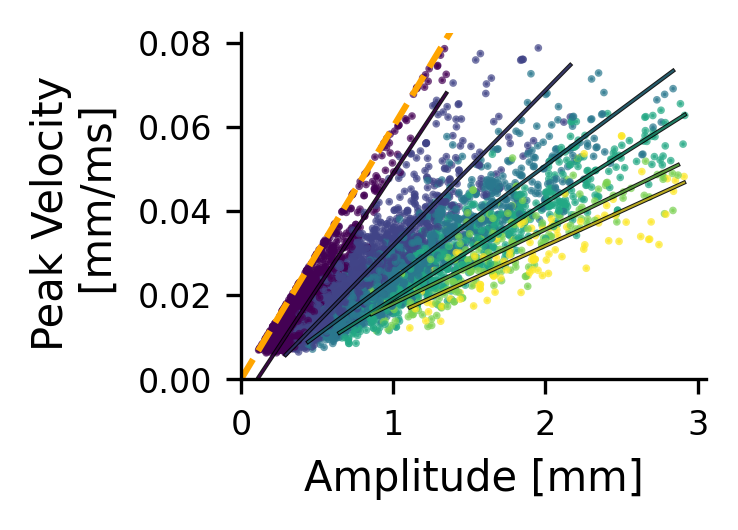

In [157]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\amplitude_velocity_length'
plot_saccade_magnitude_vs_velocity_length(synced_saccade_collection,non_synced_saccade_collection,export_path=export_path,fig_size=(2,1.5),threshold=3,velocity_threshold=None,velocity_to_mm_per_ms=True)

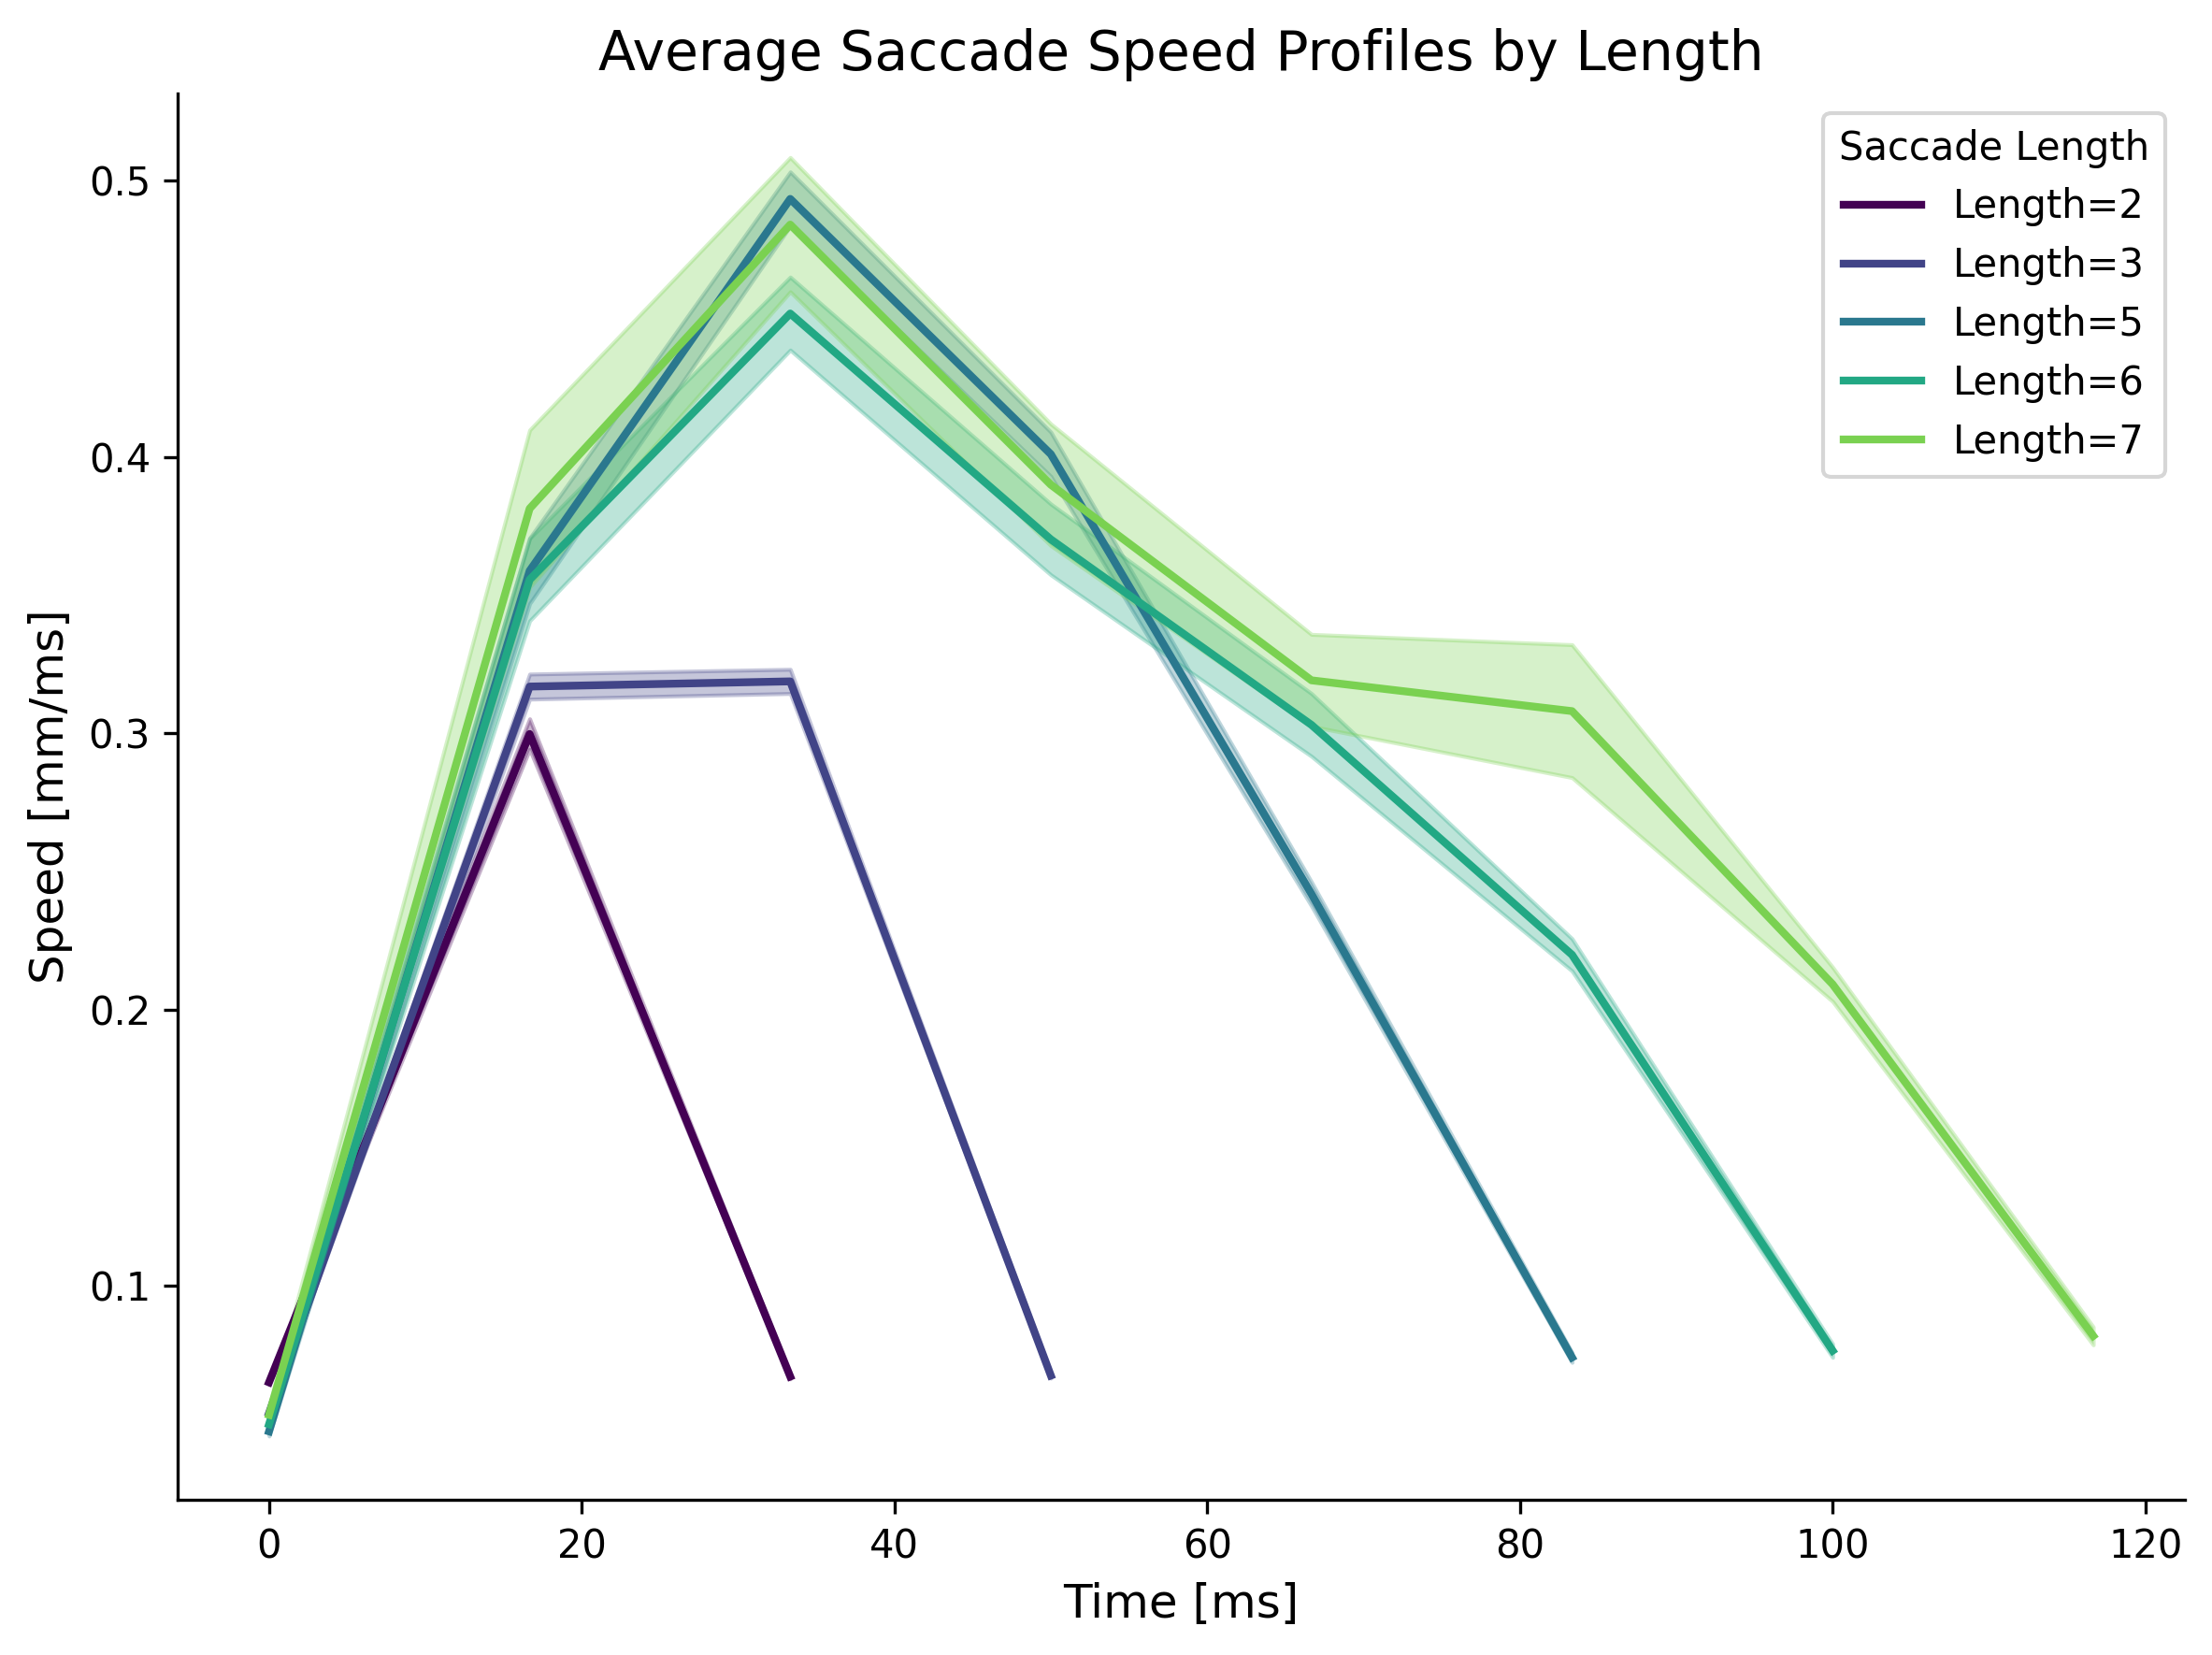

In [138]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_speed_profiles_by_length(saccade_collection, lengths_to_plot):
    """
    Plots average speed profiles for each saccade length.

    Parameters:
    - saccade_collection: DataFrame containing speed profiles
    - lengths_to_plot: List of saccade lengths to plot
    """
    fig, ax = plt.subplots(figsize=(8, 6), dpi=300)
    cmap = plt.cm.viridis

    for idx, length in enumerate(lengths_to_plot):
        # Extract speed profiles for the current length
        speed_profiles = saccade_collection.loc[
            saccade_collection['length'] == length, 'speed_profile_calib'
        ].dropna().values

        # Ensure valid data exists
        if len(speed_profiles) == 0:
            continue

        # Align speed profiles by maximum length of the group
        max_length = max(len(p) for p in speed_profiles)
        aligned_profiles = np.full((len(speed_profiles), max_length), np.nan)

        # Populate aligned profiles
        for i, profile in enumerate(speed_profiles):
            aligned_profiles[i, :len(profile)] = profile

        # Compute average and standard error
        avg_profile = np.nanmean(aligned_profiles, axis=0)
        std_error = np.nanstd(aligned_profiles, axis=0) / np.sqrt(len(speed_profiles))

        # Define time points based on sampling rate (assuming 60 fps)
        time_points = np.arange(0, len(avg_profile) * (1000 / 60), 1000 / 60)

        # Plot average line with shaded error region
        ax.plot(time_points, avg_profile, color=cmap(idx / len(lengths_to_plot)), 
                label=f'Length={length}', lw=2)
        ax.fill_between(time_points, avg_profile - std_error, avg_profile + std_error, 
                        color=cmap(idx / len(lengths_to_plot)), alpha=0.3)

    # Customize the plot
    ax.set_xlabel('Time [ms]', fontsize=12)
    ax.set_ylabel('Speed [mm/ms]', fontsize=12)
    ax.set_title('Average Saccade Speed Profiles by Length', fontsize=14)
    ax.legend(title="Saccade Length", fontsize=10)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()
plot_speed_profiles_by_length(all_saccade_collection,[2,3,5,6,7])

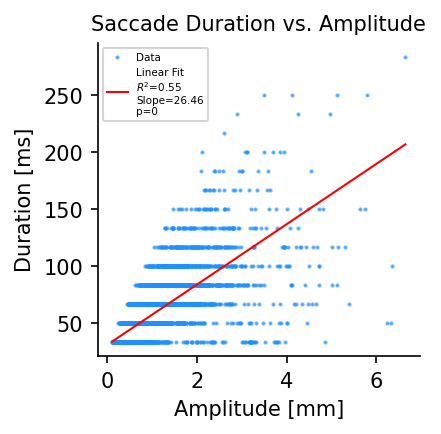

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import t

def plot_duration_vs_amplitude(saccade_collection):
    """
    Plots a scatterplot of saccade duration vs. amplitude with linear regression and p-value.

    Parameters:
    - saccade_collection: DataFrame with saccade data
    """
    try:
        # Extract relevant data and ensure numeric type
        amplitudes = pd.to_numeric(saccade_collection['magnitude'], errors='coerce').values
        durations = pd.to_numeric(saccade_collection['length'], errors='coerce').values * (1000 / 60)  # Assuming 60 fps

        # Ensure valid data by filtering out NaNs
        mask = ~np.isnan(amplitudes) & ~np.isnan(durations)
        amplitudes = amplitudes[mask].reshape(-1, 1)
        durations = durations[mask]

        # Perform linear regression
        model = LinearRegression().fit(amplitudes, durations)
        slope = model.coef_[0]
        intercept = model.intercept_
        r_squared = model.score(amplitudes, durations)

        # Predicted values
        y_pred = model.predict(amplitudes)

        # Calculate Residual Standard Error (RSE)
        residuals = durations - y_pred
        rse = np.sqrt(np.sum(residuals**2) / (len(amplitudes) - 2))

        # Calculate Standard Error of Slope
        se_slope = rse / np.sqrt(np.sum((amplitudes - amplitudes.mean())**2))

        # Calculate t-statistic and p-value
        t_stat = slope / se_slope
        df = len(amplitudes) - 2
        p_value = 2 * t.sf(np.abs(t_stat), df)

        # Generate regression line
        x_vals = np.linspace(amplitudes.min(), amplitudes.max(), 100).reshape(-1, 1)
        y_vals = model.predict(x_vals)

        # Create scatter plot
        fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
        ax.scatter(amplitudes, durations, c='dodgerblue', alpha=0.6, s=1, label='Data')
        ax.plot(x_vals, y_vals, color='red', lw=1, label=f'Linear Fit\n$R^2$={r_squared:.2f}\nSlope={slope:.2f}\np={p_value:.2g}')

        # Customize the plot
        ax.set_xlabel('Amplitude [mm]', fontsize=10)
        ax.set_ylabel('Duration [ms]', fontsize=10)
        ax.set_title('Saccade Duration vs. Amplitude', fontsize=10)
        ax.legend(fontsize=5, loc='upper left')
        ax.grid(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.tight_layout()
        plt.show()

    except KeyError as e:
        print(f"Missing key in DataFrame: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

plot_duration_vs_amplitude(all_saccade_collection)

In [148]:
print(len(all_saccade_collection.query('head_movement == False')))
print(len(all_saccade_collection.query('head_movement == True')))

4314
5094
